# Applying GrandPrix on the cell cycle single cell nCounter data of PC3 human prostate cancer
_Sumon Ahmed_, 2017, 2018

This notebooks describes how GrandPrix with informative prior over the latent space can be used to infer the cell cycle stages from the single cell nCounter data of the PC3 human prostate cancer cell line.

In [1]:
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix

# Data decription
<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4102402/" terget="_blank">McDavid et al. (2014)</a> assayed the expression profiles of the PC3 human prostate cancer cell line. They identified the cells in G0/G1, S and G2/M cell cycle stages. The cells identified as G0/G1, S and G2/M have been mapped to the capture times of 1, 2 and 3, respectively. Due to the additional challenge of optimizing pseudotime parameters for periodic data, random pseudotimes having the largest log likelihood to estimate cell cycle peak time points have been used to initilize the prior.


The __McDavidtrainingData.csv__ file contains the expression profiles of the top __56__ differentially expressed genes in __361__ cells from the PC3 human prostate cancer cell line which have been used in the inference.

The __McDavidCellMeta.csv__ file contains the additional information of the data such as capture time of each cells, different initializations of pseudotimes, etc.

In [2]:
Y = pd.read_csv('../data/McDavid/McDavidtrainingData.csv', index_col=[0]).T
mData = pd.read_csv('../data/McDavid/McDavidCellMeta.csv', index_col=[0])

In [3]:
N, D = Y.shape
print('Time Points: %s, Genes: %s'%(N, D))

Time Points: 361, Genes: 56


In [4]:
mData.head()

,c,cell,captureStatus,cellline,plate,platerow,ngeneson,obstime,S.hat,capture,capture.orig,prior
1,1,10,PC33A,s,PC3,11,A,0.956522,2,0.099553,2,3.141667
2,2,10,PC33B,s,PC3,11,B,0.968379,2,0.104718,2,0.950000
3,3,10,PC33C,s,PC3,11,C,0.857708,2,0.089802,2,3.383333
4,4,10,PC33E,s,PC3,11,E,0.948617,2,0.104967,2,1.833333
5,5,10,PC33F,s,PC3,11,F,0.913043,2,0.110594,2,3.133333


## Model with Informative prior

Capture time points have been used as the informative prior information over pseudotime. Following arguments have been passed to initialize the model.

<!--
-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.
-  __latent_prior_mean__: _array-like, shape N_ x 1, _optional (default:_ __0__). > Mean of the prior distribution over pseudotime.
-  __latent_prior_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Variance of the prior distribution over pseudotime.
-  __latent_mean__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial mean values of the approximate posterior distribution over pseudotime.
-  __latent_var__: _array-like, shape N_ x 1, _optional (default:_ __1.__). Initial variance of the approximate posterior distribution over pseudotime.
- __kernel:__ _optional (default: RBF kernel with lengthscale and variance set to 1.0)_. Covariance function to define the mapping from the latent space to the data space in Gaussian process prior. 

-->

-  __data__: _array-like, shape N x D_. Observed data, where N is the number of time points and D is the number of genes.


-  __latent_prior_mean__: _array-like, shape N_ x 1. Mean of the prior distribution over pseudotime.


-  __latent_prior_mean__: _array-like, shape N_ x 1. Mean of the prior distribution over pseudotime.


-  __latent_prior_var__: _array-like, shape N_ x 1. Variance of the prior distribution over pseudotime.


-  __latent_mean__: _array-like, shape N_ x 1. Initial mean values of the approximate posterior distribution over pseudotime.

<!--
-  __latent_var__: _array-like, shape N_ x 1. Initial variance of the approximate posterior distribution over pseudotime.
-->

- __kernel__: Covariance function to define the mapping from the latent space to the data space in Gaussian process prior. Here we have used the standard periodic covariance function <a href="http://www.ics.uci.edu/~welling/teaching/KernelsICS273B/gpB.pdf" terget="_blank">(MacKay, 1998)</a>, to restrict the Gaussian Process (GP) prior to periodic functions only.


-  __predict__: _int_. The number of new points. The mean of the expression level and associated variance of these new data points will be predicted. 

In [5]:
np.random.seed(10)
sigma_t = .5
prior_mean = mData['prior'].values[:, None]

init_mean = mData['capture.orig'].values[:, None]
X_mean = [init_mean[i, 0] + sigma_t * np.random.randn(1) for i in range(0, N)] # initialisation of latent_mean 

In [6]:
mp = GrandPrix.fit_model(data=Y.values, n_inducing_points = 20, latent_prior_mean=prior_mean, latent_prior_var=np.square(sigma_t),
               latent_mean=np.asarray(X_mean), kernel={'name':'Periodic', 'ls':5.0, 'var':1.0}, predict=100)

/Users/mqbpwsae/newInstall/GPflow_1_1_0/gpflow/expectations_quadrature.py:65: UserWarning: Quadrature is used to calculate the expectation. This means that an analytical implementations is not available for the given combination.
  warnings.warn("Quadrature is used to calculate the expectation. This means that "


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -21491.904152
  Number of iterations: 741
  Number of functions evaluations: 830


In [7]:
pseudotimes = mp[0]
posterior_var = mp[1]
mean = mp[2] # mean of predictive distribution
var = mp[3] # variance of predictive distribution

In [8]:
Xnew = np.linspace(min(pseudotimes), max(pseudotimes), 100)[:, None]

# Visualize the results
The expression profile of some interesting genes have been plotted against the estimated pseudotime. Each point corresponds to a particular gene expression in a cell. 

The points are coloured based on cell cycle stages according to <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4102402/" terget="_blank" style="text-decoration:none;">McDavid et al. (2014)</a>. The circular horizontal axis (where both first and last labels are G2/M) represents the periodicity realized by the method in pseudotime inference. 

The solid black line is the posterior predicted mean of expression profiles while the grey ribbon depicts the 95% confidence interval. 

The vertical dotted lines are the CycleBase peak times for the selected genes.

To see the expression profiles of a different set of genes a list containing gene names shound be passed to the function `plot_genes`.

In [9]:
selectedGenes = ['CDC6', 'MKI67', 'NUF2', 'PRR11', 'PTTG1', 'TPX2']

In [10]:
geneProfiles = pd.DataFrame({selectedGenes[i]: Y[selectedGenes[i]] for i in range(len(selectedGenes))})

## Binding gene names with predictive mean and variations

In [11]:
geneNames = Y.columns.values
name = [_ for _ in geneNames]
posterior_mean = pd.DataFrame(mean, columns=name)
posterior_var = pd.DataFrame(var, columns=name)

## geneData description
The __"McDavidgene.csv"__ file contains gene specific information such as peak time, etc. for the top 56 differentially expressed genes. 

In [12]:
geneData = pd.read_csv('../data/McDavid/McDavid_gene.csv', index_col=0).T


In [13]:
geneData.head()

gene,ABCF1,ALAS1,ANLN,ARL6IP1,ATF2,BCL6,BIRC5,BMP1,BTBD3,BUB1,...,UBE2C,UNG,USP1,VANGL1,VCAM1,VPS25,WDR76,ZC3HC1,ZNF367,ZRANB2
cbRank,NaN,NaN,90,16,NaN,NaN,38,NaN,207,15,...,8,252,136,194,NaN,262,171,25,48,187
cbPeaktime,NaN,NaN,89,91,NaN,NaN,94,NaN,97,92,...,81,39,56,98,NaN,71,47,91,39,40
expPeaktime,s,g2/m,g2/m,g2/m,g2/m,g0/g1,g2/m,s,s,g2/m,...,g2/m,g0/g1,s,g2/m,g2/m,g2/m,s,g2/m,s,g2/m
pvalue,2.26466,2.79702,37.9039,7.71864,0.382451,3.19427,6.87961,4.69341,12.1008,20.355,...,43.0782,24.2323,1.27999,4.02094,0.183032,4.39432,18.9298,5.63614,14.3334,0.657693


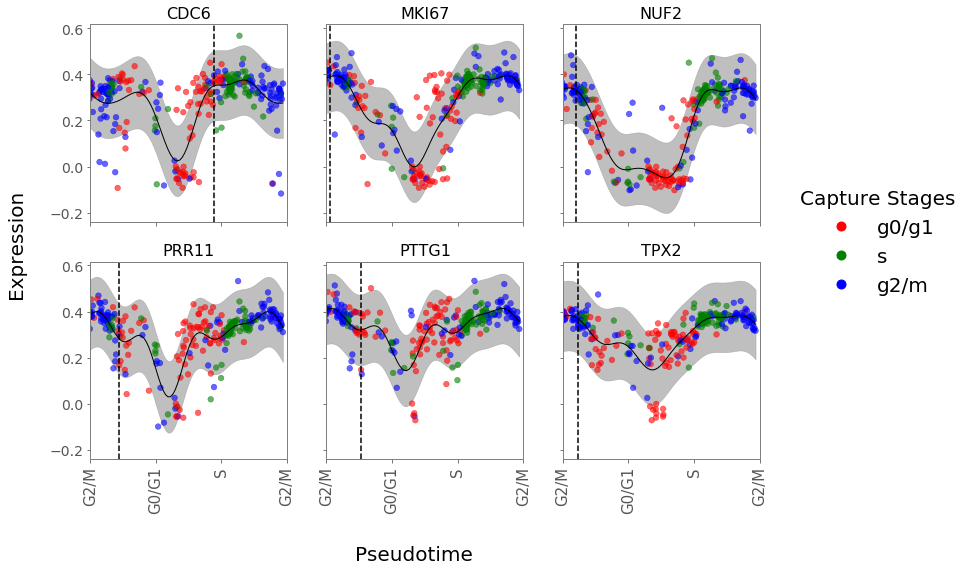

In [14]:
%matplotlib inline
from utils import plot_genes
cpt = mData['capture.orig'].values
plot_genes(pseudotimes, geneProfiles, geneData, cpt, prediction=(Xnew, posterior_mean, posterior_var))